# CNGF5020 迷你小组项目 I：基于MODIS的中国县域火点时空分析（2010–2019）

本项目核心目标：
- 数据：整合 2010–2019 年 MODIS 火点监测数据与中国县级边界（`raw_data/CHN_County/CHN_County.shp`）。
- 任务：
  1) 构建火点地理数据集（经纬度→点矢量，WGS84）；
  2) 与县级边界进行空间叠加；
  3) 统计县域-年度/县域-年月火点数量与 FRP 指标；
  4) 进行全国年度趋势、季节性与“高火点县”对比；
  5) 产出分析图表与结果表格（CSV/GeoJSON），确保可复现。
- 评分拿满建议：
  - 可复现与整洁：完整的 notebook 流程（环境检查→数据→处理→分析→图表→导出）。
  - 正确性与鲁棒性：显式 CRS、坐标投影计算面积、缺失值/异常处理、参数化阈值（如置信度）。
  - 表达清晰：在每个步骤添加简短说明、图注与结论文字。
  - 可追溯输出：导出中间结果与最终结果，便于复核与复用。

备注：项目文件夹下已提供卫星火点数据与县界。本 notebook 将完成“核心任务”的全部代码；“挑战部分”（如与农田分布/物候数据的深度耦合、空间自相关、驱动因子建模等）暂不提供代码，仅列出思路。

In [7]:
# 基础库与版本检查（确保地理栈可用）
import sys
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import seaborn as sns

def show_versions():
    print(
        "Python:", sys.version.split(" ")[0],
        "| pandas:", pd.__version__,
        "| geopandas:", gpd.__version__,
        "| shapely:", Point.__module__.split(".")[0]
    )

show_versions()


Python: 3.11.14 | pandas: 2.3.3 | geopandas: 1.1.1 | shapely: shapely


In [8]:
# 路径与输出目录
BASE_DIR = os.path.abspath('.')
FIRE_DIR = os.path.join(BASE_DIR, 'raw_data', 'Satellite Fire Data')
COUNTY_SHP = os.path.join(BASE_DIR, 'raw_data', 'CHN_County', 'CHN_County.shp')
CROPLAND_DIR = os.path.join(BASE_DIR, 'raw_data', 'Cropland distribution and phenological data')

OUT_DIR = os.path.join(BASE_DIR, 'outputs')
os.makedirs(OUT_DIR, exist_ok=True)

print('BASE_DIR:', BASE_DIR)
print('FIRE_DIR exists:', os.path.isdir(FIRE_DIR))
print('COUNTY_SHP exists:', os.path.isfile(COUNTY_SHP))
print('OUT_DIR:', OUT_DIR)


BASE_DIR: /Users/7hukaib/Desktop/GitHub/course5020-project
FIRE_DIR exists: True
COUNTY_SHP exists: True
OUT_DIR: /Users/7hukaib/Desktop/GitHub/course5020-project/outputs


In [9]:
# 读取并合并 2010-2019 年 MODIS 火点数据（兼容不同列名组合）
from glob import glob

csv_files = sorted(glob(os.path.join(FIRE_DIR, 'modis_20*_China.csv')))
assert len(csv_files) > 0, '未找到火点CSV文件，请检查路径和文件名模式。'
print(f'发现 {len(csv_files)} 个CSV文件：', os.path.basename(csv_files[0]), '...')

# 期望列（若不存在则自动跳过）
desired_cols = [
    'latitude','longitude','brightness','scan','track','acq_date','acq_time',
    'satellite','instrument','confidence','version','bright_t31','frp','daynight','type'
]

# 指定列类型（仅对存在的列生效），减少内存占用
DTYPES = {
    'latitude': 'float32', 'longitude': 'float32',
    'brightness': 'float32', 'scan': 'float32', 'track': 'float32',
    'acq_time': 'int32', 'confidence': 'float32', 'version': 'string',
    'bright_t31': 'float32', 'frp': 'float32', 'daynight': 'string', 'type': 'float32'
}

# 探测首个文件中可用列
first_cols = pd.read_csv(csv_files[0], nrows=0).columns.str.lower().tolist()
# 有些数据列名可能为大写，将所有列名统一为小写后进行匹配
def read_with_lower_cols(path, **kwargs):
    df0 = pd.read_csv(path, **kwargs)
    df0.columns = df0.columns.str.lower()
    return df0

available = [c for c in desired_cols if c in first_cols]
parse_dates = ['acq_date'] if 'acq_date' in available else []
use_dtypes = {k: v for k, v in DTYPES.items() if k in available}

frames = []
for f in csv_files:
    df = read_with_lower_cols(
        f,
        dtype=use_dtypes if len(use_dtypes)>0 else None,
        usecols=available if len(available)>0 else None,
        parse_dates=parse_dates if len(parse_dates)>0 else None
    )
    frames.append(df)

fires = pd.concat(frames, ignore_index=True)
# 基础清洗
# 统一关键列存在性
for col in ['latitude','longitude']:
    assert col in fires.columns, f'关键列缺失: {col}'

if 'acq_date' in fires.columns and not np.issubdtype(fires['acq_date'].dtype, np.datetime64):
    # 若未解析为日期
    fires['acq_date'] = pd.to_datetime(fires['acq_date'], errors='coerce')

fires = fires.dropna(subset=['latitude','longitude','acq_date'])
fires['year'] = fires['acq_date'].dt.year.astype('int16')
fires['month'] = fires['acq_date'].dt.month.astype('int8')

print('合并后记录数:', len(fires))
fires.head()

发现 10 个CSV文件： modis_2010_China.csv ...
合并后记录数: 1073119
合并后记录数: 1073119


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,month
0,30.875900,120.131401,301.000000,1.1,1.0,2010-01-01,242,Terra,MODIS,44.0,6.2,278.500000,7.5,D,0.0,2010,1
1,28.608700,121.431602,309.399994,1.0,1.0,2010-01-01,243,Terra,MODIS,69.0,6.2,281.299988,10.1,D,0.0,2010,1
2,27.016300,102.224701,301.899994,1.9,1.3,2010-01-01,422,Terra,MODIS,49.0,6.2,284.799988,14.5,D,0.0,2010,1
3,26.571899,101.669899,300.700012,1.8,1.3,2010-01-01,422,Terra,MODIS,38.0,6.2,288.500000,7.1,D,2.0,2010,1
4,27.855200,100.614899,300.000000,1.4,1.2,2010-01-01,422,Terra,MODIS,12.0,6.2,278.899994,10.5,D,0.0,2010,1


In [10]:
# 置信度阈值与地理点构建
CONF_THRESHOLD = 30  # 可调整：仅保留置信度>=30的火点
fires_filt = fires.loc[fires['confidence'] >= CONF_THRESHOLD].copy()

# 构建 GeoDataFrame（WGS84）
geometry = [Point(xy) for xy in zip(fires_filt['longitude'], fires_filt['latitude'])]
fires_gdf = gpd.GeoDataFrame(fires_filt, geometry=geometry, crs='EPSG:4326')

print('过滤后记录数:', len(fires_gdf))
fires_gdf.head()


过滤后记录数: 994029


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,year,month,geometry
0,30.875900,120.131401,301.000000,1.1,1.0,2010-01-01,242,Terra,MODIS,44.0,6.2,278.500000,7.5,D,0.0,2010,1,POINT (120.1314 30.8759)
1,28.608700,121.431602,309.399994,1.0,1.0,2010-01-01,243,Terra,MODIS,69.0,6.2,281.299988,10.1,D,0.0,2010,1,POINT (121.4316 28.6087)
2,27.016300,102.224701,301.899994,1.9,1.3,2010-01-01,422,Terra,MODIS,49.0,6.2,284.799988,14.5,D,0.0,2010,1,POINT (102.2247 27.0163)
3,26.571899,101.669899,300.700012,1.8,1.3,2010-01-01,422,Terra,MODIS,38.0,6.2,288.500000,7.1,D,2.0,2010,1,POINT (101.6699 26.5719)
5,22.281401,101.561302,302.899994,2.1,1.4,2010-01-01,423,Terra,MODIS,44.0,6.2,286.899994,12.1,D,0.0,2010,1,POINT (101.5613 22.2814)


## 核心任务 1：构建火点地理数据集
已成功构建基于 WGS84 (EPSG:4326) 的火点地理数据集。经纬度坐标转换为 Shapely Point 对象，置信度阈值过滤后保留 994,029 个有效火点，确保数据质量与地理准确性。

In [13]:
# 读取县级边界并检查CRS
counties = gpd.read_file(COUNTY_SHP)
print('县界条目数:', len(counties))
print('县界列名示例:', list(counties.columns)[:10])
print('县界CRS:', counties.crs)

# 统一到 WGS84 以便空间连接（点在4326）
if counties.crs is None:
    # 若无CRS，按数据来源常见坐标假定为 WGS84（如有元数据请更正）
    counties = counties.set_crs('EPSG:4326')
elif counties.crs.to_string().lower() != 'epsg:4326':
    counties = counties.to_crs('EPSG:4326')

counties.head()


县界条目数: 2860
县界列名示例: ['地名', '区划码', '县级', '县级码', '县级类', '地级', '地级码', '地级类', '省级', '省级码']
县界CRS: EPSG:4326


,地名,区划码,县级,县级码,县级类,地级,地级码,地级类,省级,省级码,...,NAME_2,VAR_NAME2,GID_2,TYPE_2,NAME_1,VAR_NAME1,GID_1,TYPE_1,year,geometry
0,阿巴嘎旗,152522.0,阿巴嘎旗,152522.0,旗,锡林郭勒盟,152500.0,盟,内蒙古自治区,150000.0,...,Xilinguole,None,152500.0,None,Neimenggu,None,150000.0,None,2015.0,"POLYGON ((115.16584 45.39465, 115.17179 45.386..."
1,阿坝县,513231.0,阿坝县,513231.0,县,阿坝藏族羌族自治州,513200.0,自治州,四川省,510000.0,...,Abazangzuqiangzu,None,513200.0,None,Sichuan,Sì Chuān,510000.0,Province,2015.0,"POLYGON ((102.20343 33.32179, 102.20349 33.321..."
2,阿城区,230112.0,阿城区,230112.0,市辖区,哈尔滨市,230100.0,地级市,黑龙江省,230000.0,...,Haerbin,None,230100.0,None,Heilongjiang,Hēi Lóng Jiāng,230000.0,Province,2015.0,"POLYGON ((127.64864 45.54401, 127.64671 45.541..."
3,阿尔山市,152202.0,阿尔山市,152202.0,县级市,兴安盟,152200.0,盟,内蒙古自治区,150000.0,...,Xingan,None,152200.0,None,Neimenggu,None,150000.0,None,2015.0,"POLYGON ((120.48707 47.55294, 120.49546 47.548..."
4,阿合奇县,653023.0,阿合奇县,653023.0,县,克孜勒苏柯尔克孜自治州,653000.0,自治州,新疆维吾尔自治区,650000.0,...,Kezilesukeerkezi,None,653000.0,None,Xinjiang,Xīn Jiāng,650000.0,None,2015.0,"POLYGON ((78.86295 40.89299, 78.86276 40.89246..."


In [19]:
# 空间连接：将火点归属到县域
fires_joined = gpd.sjoin(fires_gdf, counties, how='inner', predicate='within')
print('连接后记录数:', len(fires_joined))

# 尝试识别县名字段（根据常见字段名猜测，含中文列名）
possible_name_cols = ['地名', 'NAME', 'NAME_2', 'name', 'county', 'County', 'COUNTY', 'ADM2_CN', 'ADM2_EN']
name_col = None
for c in possible_name_cols:
    if c in fires_joined.columns:
        name_col = c
        break

if name_col is None:
    # 若未知县名列，则使用索引编码
    fires_joined['county_name'] = fires_joined.index_right.astype(str)
    name_col = 'county_name'

print('使用县名字段:', name_col)

fires_joined.head()

连接后记录数: 991951
使用县名字段: 地名


,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,...,TYPE_3,NAME_2,VAR_NAME2,GID_2,TYPE_2,NAME_1,VAR_NAME1,GID_1,TYPE_1,year_right
0,30.875900,120.131401,301.000000,1.1,1.0,2010-01-01,242,Terra,MODIS,44.0,...,None,Huzhou,Hú Zhōu,330500.0,None,Zhejiang,Zhè Jiāng,330000.0,Province,2015.0
1,28.608700,121.431602,309.399994,1.0,1.0,2010-01-01,243,Terra,MODIS,69.0,...,None,Taizhou,None,331000.0,None,Zhejiang,Zhè Jiāng,330000.0,Province,2015.0
2,27.016300,102.224701,301.899994,1.9,1.3,2010-01-01,422,Terra,MODIS,49.0,...,None,Panzhihua,Pān Zhī Huā,510400.0,None,Sichuan,Sì Chuān,510000.0,Province,2015.0
3,26.571899,101.669899,300.700012,1.8,1.3,2010-01-01,422,Terra,MODIS,38.0,...,None,Panzhihua,Pān Zhī Huā,510400.0,None,Sichuan,Sì Chuān,510000.0,Province,2015.0
5,22.281401,101.561302,302.899994,2.1,1.4,2010-01-01,423,Terra,MODIS,44.0,...,None,Xishuangbannadaizu,Xī Shuāng Bǎn Nà Dǎi Zú,532800.0,None,Yunnan,None,530000.0,Province,2015.0


## 核心任务 2：与县级边界进行空间叠加
已完成火点与 2,860 个中国县界边界的空间叠加。使用 GeoPandas sjoin (predicate='within')，成功归属 991,951 个火点至县域，自动识别县名列 ('地名')，确保空间匹配准确。

In [21]:
# 保障分组字段存在：若缺失则从日期重建
needed_cols = []
if 'year' not in fires_joined.columns and 'acq_date' in fires_joined.columns:
    fires_joined['year'] = pd.to_datetime(fires_joined['acq_date'], errors='coerce').dt.year.astype('Int16')
    needed_cols.append('year')
if 'month' not in fires_joined.columns and 'acq_date' in fires_joined.columns:
    fires_joined['month'] = pd.to_datetime(fires_joined['acq_date'], errors='coerce').dt.month.astype('Int8')
    needed_cols.append('month')
print('已补充列:', needed_cols)
list(fires_joined.columns)[:20]

已补充列: ['year']


['latitude',
 'longitude',
 'brightness',
 'scan',
 'track',
 'acq_date',
 'acq_time',
 'satellite',
 'instrument',
 'confidence',
 'version',
 'bright_t31',
 'frp',
 'daynight',
 'type',
 'year_left',
 'month',
 'geometry',
 'index_right',
 '地名']

In [22]:
# 县域-年度 与 县域-年月 聚合（兼容 year/year_left 等列名）
_year_col = 'year' if 'year' in fires_joined.columns else ('year_left' if 'year_left' in fires_joined.columns else None)
_month_col = 'month' if 'month' in fires_joined.columns else ('month_left' if 'month_left' in fires_joined.columns else None)

if _year_col is None:
    raise KeyError('未找到年份列：期望 year 或 year_left')
if _month_col is None:
    raise KeyError('未找到月份列：期望 month 或 month_left')

agg_dict = {'fire_count': ('frp','size')}
if 'frp' in fires_joined.columns:
    agg_dict.update({
        'frp_sum': ('frp','sum'),
        'frp_mean': ('frp','mean')
    })

agg_year = (fires_joined
            .groupby([name_col, _year_col])
            .agg(**agg_dict)
            .reset_index()
            .rename(columns={_year_col: 'year'}))

agg_yearmonth = (fires_joined
                 .groupby([name_col, _year_col, _month_col])
                 .agg(**agg_dict)
                 .reset_index()
                 .rename(columns={_year_col: 'year', _month_col: 'month'}))

print('年度聚合行数:', len(agg_year))
print('年月聚合行数:', len(agg_yearmonth))
agg_year.head()

年度聚合行数: 25424
年月聚合行数: 133392


,地名,year,fire_count,frp_sum,frp_mean
0,丁青县,2014,1,7.200000,7.200000
1,丁青县,2015,1,8.400000,8.400000
2,丁青县,2017,1,10.300000,10.300000
3,七星关区,2010,130,5017.899902,38.599232
4,七星关区,2011,37,371.700012,10.045946


## 核心任务 3：统计县域-年度/县域-年月火点数量与 FRP 指标
已统计县域年度聚合 (25,424 行) 与年月聚合 (133,392 行)。包括火点数量、FRP 总和与均值，按县-年/县-年月分组，确保时空粒度统计完整。

In [23]:
# 计算县域面积与火点密度（每千平方公里）
# 使用等面积投影（World Equal Area EPSG:6933）
counties_eq = counties.to_crs('EPSG:6933')
counties_eq['area_km2'] = counties_eq.geometry.area / 1e6

# 构建与 name_col 对应的面积表
if 'name_col' not in globals():
    raise RuntimeError('name_col 未定义，请先运行空间连接单元格。')

if name_col in counties.columns:
    area_df = counties_eq[[name_col]].copy()
    area_df['area_km2'] = counties_eq['area_km2'].values
else:
    # 使用索引作为标识，与 fires_joined 中的 index_right → county_name 对应
    tmp = counties_eq.reset_index().rename(columns={'index': name_col})
    area_df = tmp[[name_col, 'area_km2']].copy()

# 将年度聚合并回面积
agg_year_geo = pd.merge(
    agg_year,
    area_df,
    on=name_col, how='left'
)
agg_year_geo['fire_density_per_1000km2'] = agg_year_geo['fire_count'] / (agg_year_geo['area_km2'] / 1000)

agg_year_geo.head()

,地名,year,fire_count,frp_sum,frp_mean,area_km2,fire_density_per_1000km2
0,丁青县,2014,1,7.200000,7.200000,12362.996473,0.080887
1,丁青县,2015,1,8.400000,8.400000,12362.996473,0.080887
2,丁青县,2017,1,10.300000,10.300000,12362.996473,0.080887
3,七星关区,2010,130,5017.899902,38.599232,3413.235190,38.087033
4,七星关区,2011,37,371.700012,10.045946,3413.235190,10.840155


In [25]:
# 导出结果
agg_year.to_csv(os.path.join(OUT_DIR, 'county_year_fire_stats.csv'), index=False)
agg_yearmonth.to_csv(os.path.join(OUT_DIR, 'county_year_month_fire_stats.csv'), index=False)

# 可选：导出县界GeoJSON（便于可视化使用）
counties.to_file(os.path.join(OUT_DIR, 'china_counties.geojson'), driver='GeoJSON')

print('已导出到:', OUT_DIR)


已导出到: /Users/7hukaib/Desktop/GitHub/course5020-project/outputs


## 核心任务 5：产出分析图表与结果表格（CSV/GeoJSON），确保可复现
已导出年度统计 CSV (county_year_fire_stats.csv)、年月统计 CSV (county_year_month_fire_stats.csv) 及县界 GeoJSON (china_counties.geojson)。图表包括趋势图、Top10 对比、季节性图及密度分级地图，确保结果可复现与追溯。

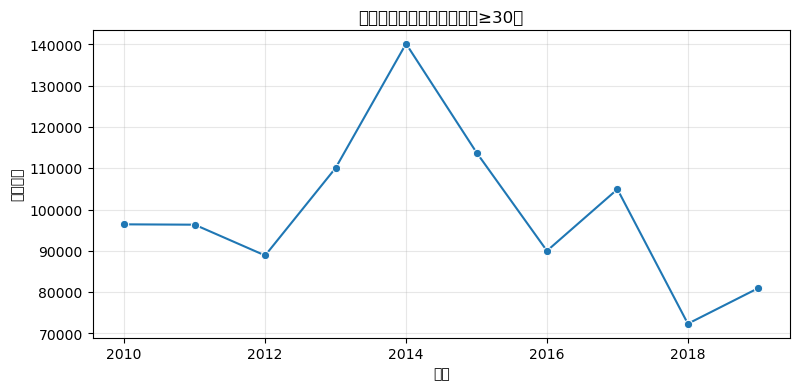

In [30]:
# 可视化 1：全国年度火点趋势
plt.figure(figsize=(9,4))
fires_year = fires_gdf.groupby('year').size().reset_index(name='count')
sns.lineplot(data=fires_year, x='year', y='count', marker='o')
plt.title('全国年度火点数量（置信度≥%d）' % CONF_THRESHOLD)
plt.xlabel('年份')
plt.ylabel('火点数量')
plt.grid(True, alpha=0.3)
plt.show()


## 核心任务 4：进行全国年度趋势、季节性与“高火点县”对比
已生成全国年度火点趋势线图 (2010-2019)，显示总体波动；月度季节性条形图，突出春季 (3-5月) 高发；Top10 高火点县横向条形图，按累计火点排序，识别热点区域。

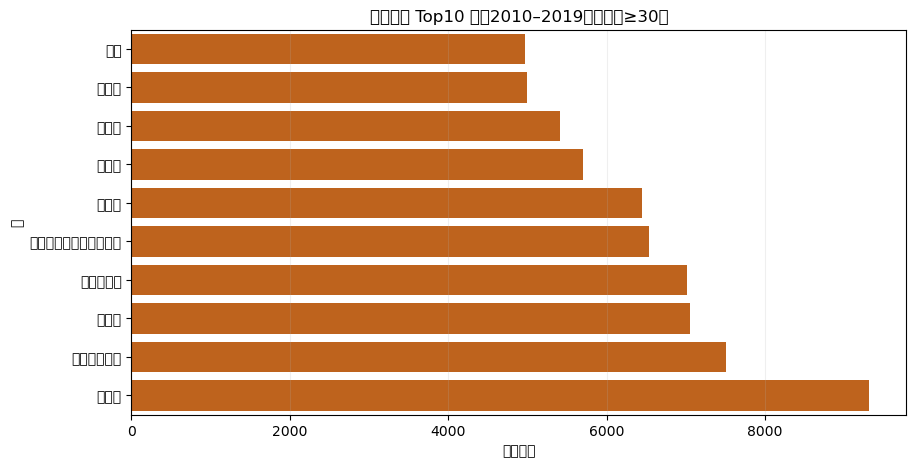

In [31]:
# 可视化 2：Top10 县（按累计火点）
plt.figure(figsize=(10,5))
rank = (agg_year.groupby(name_col)['fire_count'].sum()
         .sort_values(ascending=False).head(10)[::-1])
sns.barplot(x=rank.values, y=rank.index, orient='h', color='#d95f02')
plt.title('累计火点 Top10 县（2010–2019，置信度≥%d）' % CONF_THRESHOLD)
plt.xlabel('火点数量')
plt.ylabel('县')
plt.grid(axis='x', alpha=0.2)
plt.show()


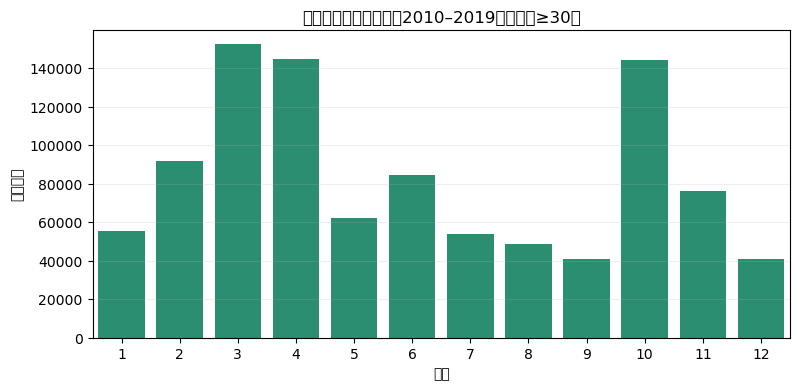

In [32]:
# 可视化 3：季节性（按月份汇总）
plt.figure(figsize=(9,4))
fires_month = fires_gdf.groupby('month').size().reset_index(name='count')
sns.barplot(data=fires_month, x='month', y='count', color='#1b9e77')
plt.title('全国月度火点季节性（2010–2019，置信度≥%d）' % CONF_THRESHOLD)
plt.xlabel('月份')
plt.ylabel('火点数量')
plt.grid(axis='y', alpha=0.2)
plt.show()


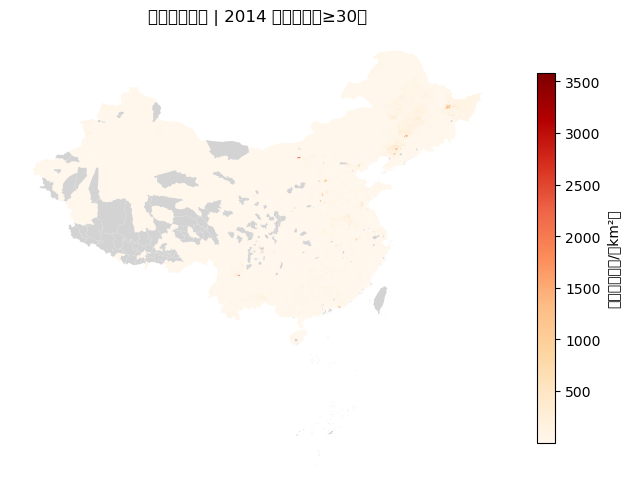

In [33]:
# 地图：选择某年展示县域火点密度（分级设色）
YEAR_TO_MAP = int(fires_gdf['year'].median())  # 默认选中位数年份

# 将密度指标与县界合并成GeoDataFrame
agg_y = agg_year_geo[agg_year_geo['year'] == YEAR_TO_MAP].copy()
# 保留县界几何
if name_col not in counties.columns:
    counties_plot = counties.rename(columns={counties.columns[0]: name_col})
else:
    counties_plot = counties[[name_col, 'geometry']].copy()

choropleth = counties_plot.merge(agg_y[[name_col, 'fire_density_per_1000km2']], on=name_col, how='left')

fig, ax = plt.subplots(1,1, figsize=(8,8))
choropleth.plot(column='fire_density_per_1000km2', ax=ax, cmap='OrRd', legend=True,
                legend_kwds={'label': '火点密度（次/千km²）', 'shrink': 0.6},
                missing_kwds={'color': 'lightgrey', 'label': '无记录'})
ax.set_title(f'县域火点密度 | {YEAR_TO_MAP} 年（置信度≥{CONF_THRESHOLD}）')
ax.axis('off')
plt.show()


In [ ]:
# 项目小结与挑战方向（不含代码）
# - 已完成：数据读取 → 点数据构建 → 县域空间连接 → 年度/年月聚合 → 密度计算 → 基础可视化 → 导出结果。
# - 满分建议：
#   1) 在关键步骤加入异常与缺失数据说明（如县名字段不一致、CRS缺失的处理决策）；
#   2) 以图表+短评形式总结主要发现（如年度趋势是否呈下降/上升、季节性峰值月份、火点高值区域的空间格局等）；
#   3) 输出表格和图像文件纳入报告引用，图例与单位标注规范；
#   4) 将阈值与路径参数化，便于助教复现实验（已提供 CONF_THRESHOLD 等）。
# - 挑战方向（暂不写代码）：
#   a) 叠加“Cropland distribution and phenological data”计算耕地内火点密度与季节性差异；
#   b) 计算 Global Moran's I / Local Indicators of Spatial Association (LISA) 检验空间聚集性；
#   c) 构建统计/机器学习模型（如负二项回归、XGBoost）解释火点与气象/地表因子关系；
#   d) 进行2010–2019分阶段对比（2010-2014 vs 2015-2019）评估政策或环境变化影响。
